In [23]:
import scipy
import numpy as np
from sklearn.metrics import pairwise_distances
import networkx as nx
import pandas as pd

In [24]:
POINTS_ARRAY = np.random.uniform(size = (5,3))
POINTS_ARRAY

array([[0.9044345 , 0.51217933, 0.75192215],
       [0.03680006, 0.57309371, 0.0762018 ],
       [0.46945996, 0.44282868, 0.82460132],
       [0.65501228, 0.46051189, 0.73853924],
       [0.86901818, 0.66629506, 0.7716513 ]])

In [25]:
distance_matrix = pairwise_distances(POINTS_ARRAY).round(2)
distance_matrix

array([[0.  , 1.1 , 0.45, 0.26, 0.16],
       [1.1 , 0.  , 0.87, 0.91, 1.09],
       [0.45, 0.87, 0.  , 0.21, 0.46],
       [0.26, 0.91, 0.21, 0.  , 0.3 ],
       [0.16, 1.09, 0.46, 0.3 , 0.  ]])

In [26]:
mst = scipy.sparse.csgraph.minimum_spanning_tree(distance_matrix)
print(mst)

  (0, 3)	0.26
  (0, 4)	0.16
  (2, 1)	0.87
  (3, 2)	0.21


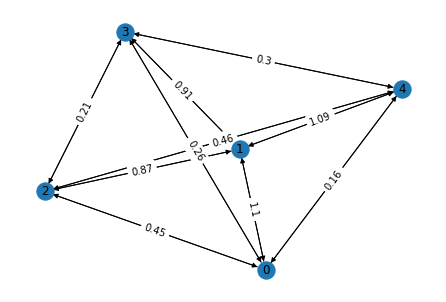

In [27]:
G = nx.from_numpy_matrix(distance_matrix, create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
labels = nx.get_edge_attributes(G, "weight")
_ = nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

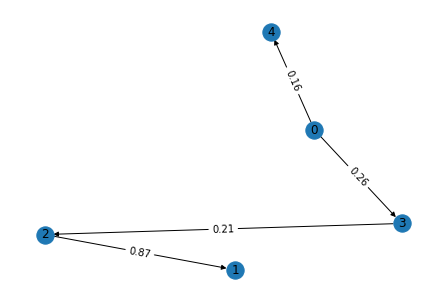

In [28]:
G = nx.from_numpy_matrix(mst.toarray(), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
labels = nx.get_edge_attributes(G, "weight")
_ = nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

In [29]:
mst_cords = mst.tocoo()
mst_df = pd.DataFrame({'src':mst_cords.row, 'dst':mst_cords.col, 'dist':mst_cords.data})
mst_df.sort_values(by='dist').reset_index(drop = True)

,src,dst,dist
0,0,4,0.16
1,3,2,0.21
2,0,3,0.26
3,2,1,0.87


In [30]:
class NaiveDisjoinSet:
    def __init__(self, n_points):
        self.universal = [{i} for i in range(n_points)]
    def Find(self, a):
        for ele in self.universal:
            if a in ele:
                return ele
        raise Exception("Element Not Found")
    def Union(self, a, b):
        s1 = self.Find(a)
        s2 = self.Find(b)
        if s1 == s2:
            raise Exception("Elements belong to same set")
        s3 = s1.union(s2)
        self.universal.remove(s1)
        self.universal.remove(s2)
        self.universal.append(s3)
        
        
        
nd = NaiveDisjoinSet(5)
nd.Find(2)
nd.Union(1, 2)
nd.Find(2)
nd.Union(3, 1)
nd.Find(1)
nd.Find(2)
nd.Find(4)

{4}